
## 📌 **Project Overview**
This project applies *Convolutional Neural Networks (CNNs)* to a *Natural Language Processing (NLP)* task:  
*classifying emotions from text data*.  

The dataset contains sentences labeled with emotions such as *joy, sadness, anger, fear, love, and surprise*.  
Our goal is to build a deep learning model that can automatically detect the underlying emotion in a given sentence.

---

# 🎯 **Objectives**
- Perform text preprocessing (tokenization, padding).  
- Use an *Embedding layer* to convert words into dense vectors.  
- Build a *CNN-based model* to capture local patterns in text.  
- Train and evaluate the model on the dataset.  
- Visualize performance and analyze metrics like *accuracy, precision, recall, and F1-score*.  

---

# 📂 **Dataset**
- *Source*: [Kaggle - Emotions Dataset for NLP](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)  
- *Format*: CSV file with:  
  - text → input sentence/phrase.  
  - emotion → target label (emotion category).  

---

# **🛠 Tools & Libraries**
- Python   
- TensorFlow / Keras 
- NumPy & Pandas   
- Matplotlib   
- scikit-learn   

---

# **Expected Outcome**
By the end of this notebook, we will have:  
- A trained *CNN model* applied to an *NLP problem* (emotion classification).  
- Visualized results of the training process.  
- Evaluation metrics showing how well the model predicts unseen text data.


# 🔗 **How CNN fits into NLP**


         ┌───────────────────────┐
         │     Text Data (NLP)   │
         │ (sentences, words...) │
         └────────────┬──────────┘
                      │
                      ▼
         ┌───────────────────────┐
         │     Preprocessing     │
         │ (tokenization,        │
         │  padding, embedding)  │
         └────────────┬──────────┘
                      │
                      ▼
         ┌───────────────────────┐
         │   CNN Model (Conv1D)  │
         │  - Convolution        │
         │  - Pooling            │
         │  - Dense Layers       │
         └────────────┬──────────┘
                      │
                      ▼
         ┌───────────────────────┐
         │   Predicted Emotion   │
         │ (joy, anger, etc.)    │
         └───────────────────────┘



  


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout




2025-08-16 09:12:02.791248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755335522.985246      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755335523.048244      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#  **Load the dataset (Kaggle dataset: emotions.csv)**


In [2]:
train_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt", sep=";", names=["text", "emotion"])
test_df  = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt", sep=";", names=["text", "emotion"])
val_df   = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt", sep=";", names=["text", "emotion"])

# Combine train + val for full training set
df = pd.concat([train_df, val_df], ignore_index=True)

print(df.head())

                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


# 🔎 **Exploratory Data Analysis (EDA)**

Before training the CNN model, let's explore the dataset to better understand its structure, class distribution, and text properties.  

The main goals of this section are:
- Analyze the *distribution of emotions*.  
- Inspect the *length of sentences*.  
- Visualize *frequent words* using word clouds.

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


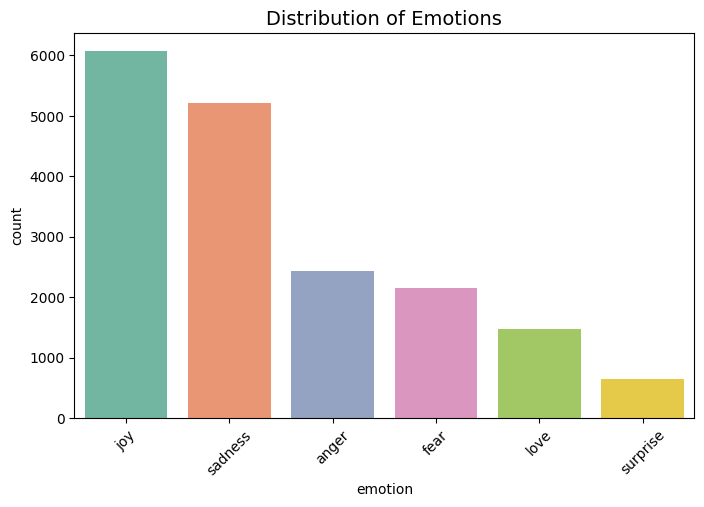

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


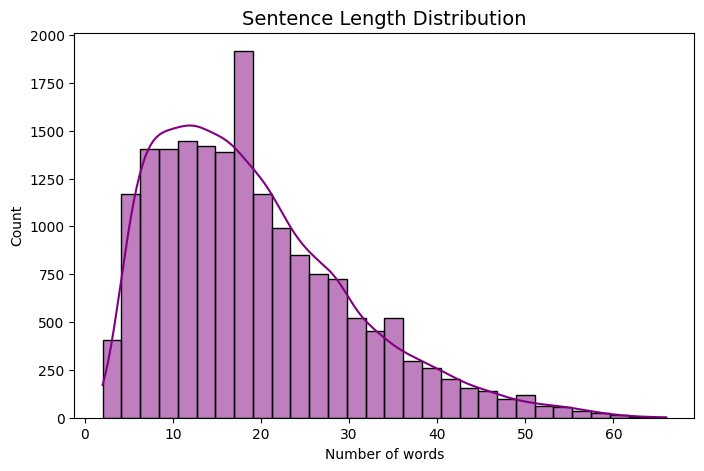

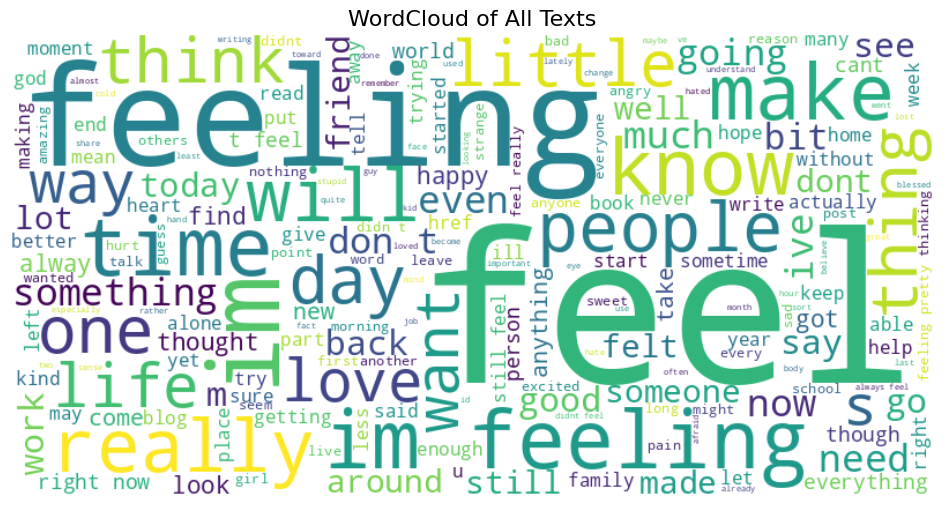

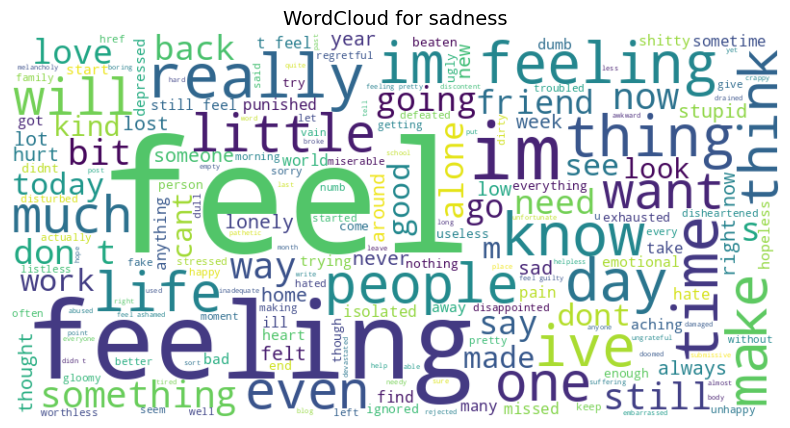

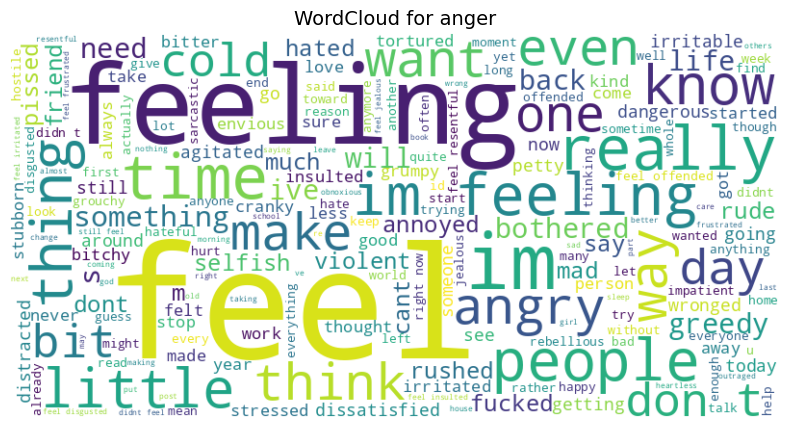

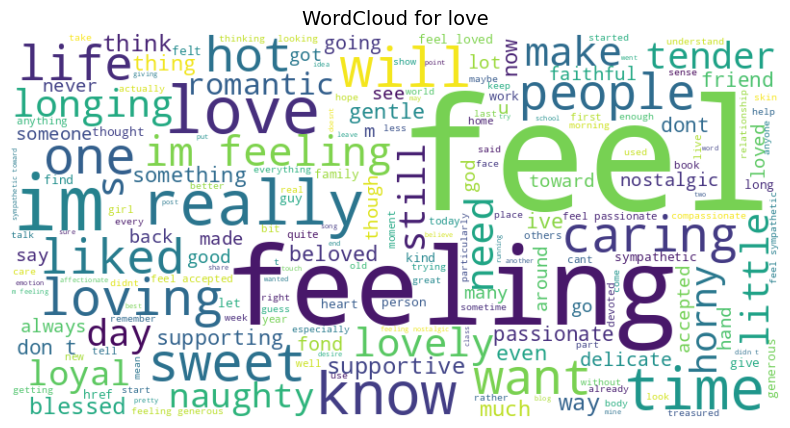

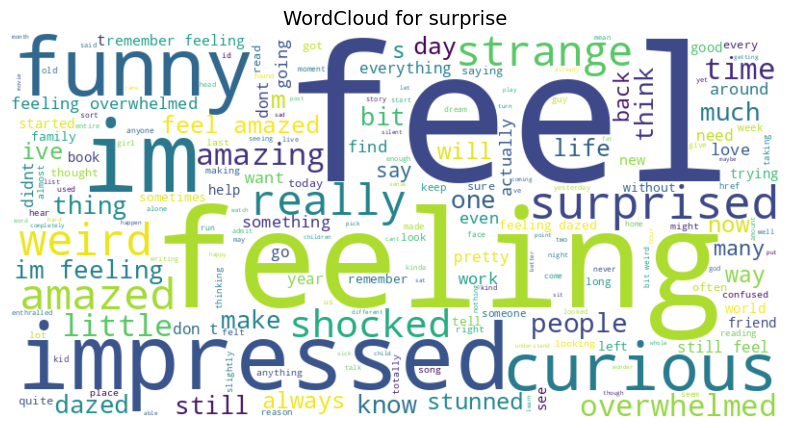

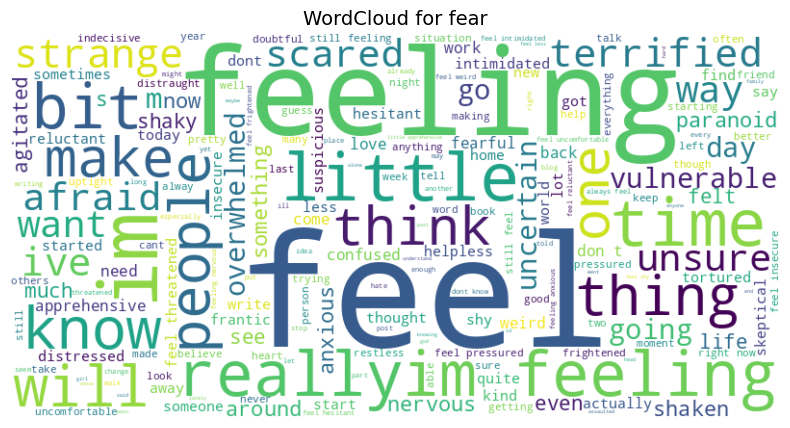

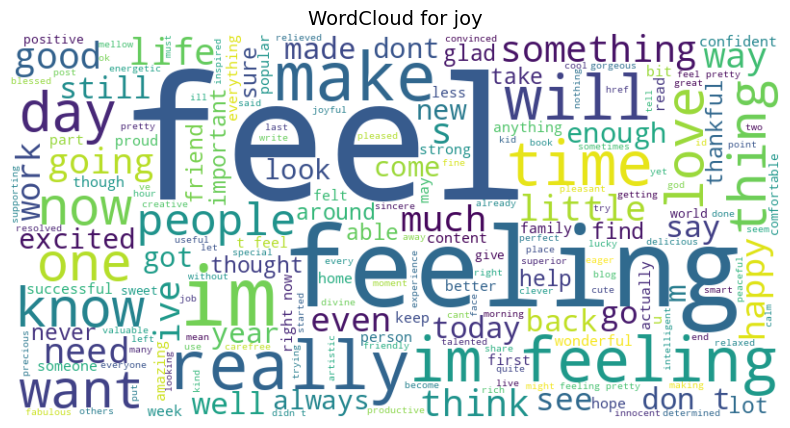

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


#  Distribution of emotions
plt.figure(figsize=(8,5))
sns.countplot(x="emotion", data=df, order=df['emotion'].value_counts().index, palette="Set2")
plt.title("Distribution of Emotions", fontsize=14)
plt.xticks(rotation=45)
plt.show()

#  Sentence length analysis
df["sentence_length"] = df["text"].apply(lambda x: len(word_tokenize(str(x))))
plt.figure(figsize=(8,5))
sns.histplot(df["sentence_length"], bins=30, kde=True, color="purple")
plt.title("Sentence Length Distribution", fontsize=14)
plt.xlabel("Number of words")
plt.show()

#  WordCloud for all text
all_text = " ".join(df["text"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of All Texts", fontsize=16)
plt.show()

#  WordCloud per emotion
emotions = df["emotion"].unique()
for emotion in emotions:
    text = " ".join(df[df["emotion"]==emotion]["text"].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {emotion}", fontsize=14)
    plt.show()

In [4]:
texts = df['text'].astype(str).tolist()
labels = df['emotion'].tolist()

#  **Encode the labels (convert emotions into integers)**


In [5]:
encoder = LabelEncoder()
y = encoder.fit_transform(labels)


#  **Prepare text sequences**


In [6]:
max_words = 10000   # keep the top 10k most frequent words
max_len = 100       # maximum length of each text

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=max_len, padding='post')


#  **Train/Test split**


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  **Build CNN model**


In [8]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(encoder.classes_), activation='softmax')  # number of classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1755335577.519034      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


#  **Train**


In [9]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2)


Epoch 1/5


I0000 00:00:1755335579.683423      62 service.cc:148] XLA service 0x7d7a040087b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755335579.684049      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755335579.997016      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


 56/360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2962 - loss: 1.6633

I0000 00:00:1755335582.276405      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3617 - loss: 1.5511 - val_accuracy: 0.8458 - val_loss: 0.4901
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8764 - loss: 0.3827 - val_accuracy: 0.9163 - val_loss: 0.1970
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9524 - loss: 0.1408 - val_accuracy: 0.9156 - val_loss: 0.1902
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9730 - loss: 0.0837 - val_accuracy: 0.9108 - val_loss: 0.2267
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9816 - loss: 0.0569 - val_accuracy: 0.9187 - val_loss: 0.2368


#  **Evaluate**


In [10]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9189 - loss: 0.2466
Test Accuracy: 0.92


#  **Prediction example**


In [11]:
sample_texts = [
    "I am so happy today!",
    "I feel very sad and lonely",
    "This makes me really angry!",
    "I am surprised by the news"
]

seq = tokenizer.texts_to_sequences(sample_texts)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)

for i, t in enumerate(sample_texts):
    emotion = encoder.classes_[pred[i].argmax()]
    print(f"{t} → {emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
I am so happy today! → joy
I feel very sad and lonely → sadness
This makes me really angry! → anger
I am surprised by the news → surprise
